# Vehicle Detection Project

The goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
- Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.

## 1. HOG feature extraction and SVM classify

In [15]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import random
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
%matplotlib inline

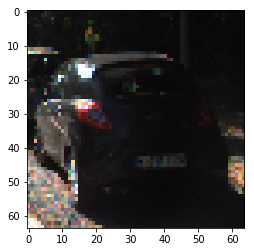

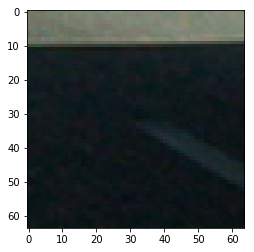

In [2]:
vehicles = glob.glob('vehicles/KITTI_extracted/*.png')
nonvehicles = glob.glob('non-vehicles/GTI/*.png')

plt.figure(1)
img1 = mpimg.imread(vehicles[0])
plt.imshow(img1)
plt.figure(2)
img2 = mpimg.imread(nonvehicles[0])
plt.imshow(img2)

In [3]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:   
        features = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=vis, feature_vector=feature_vec)
        return features

/Users/xu/miniconda2/envs/tensorflow/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


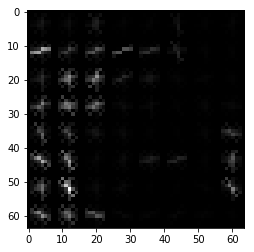

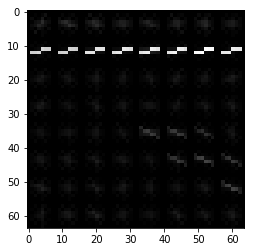

In [4]:
gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
feat1, hog1 = get_hog_features(gray1, 9, 8, 2, vis=True, feature_vec=False)
feat2, hog2 = get_hog_features(gray2, 9, 8, 2, vis=True, feature_vec=False)
plt.figure(1)
plt.imshow(hog1, cmap='gray')
plt.figure(2)
plt.imshow(hog2, cmap='gray')

In [5]:
car_features = []
notcar_features = []
for image in vehicles:
    img = mpimg.imread(image)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hog_feature = get_hog_features(gray, 9, 8, 2)
    car_features.append(hog_feature)
for image in nonvehicles:
    img = mpimg.imread(image)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hog_feature = get_hog_features(gray, 9, 8, 2)
    notcar_features.append(hog_feature)

/Users/xu/miniconda2/envs/tensorflow/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [6]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
X_scaler = StandardScaler().fit(X)
scaler_X = X_scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(scaler_X, y, test_size=0.2, random_state=np.random.randint(0,100))

svc = LinearSVC()
svc.fit(X_train, y_train)
pred = svc.predict(X_test)
accuracy_score(y_test, pred)

## 2. Applying color transform

In [9]:
def extract_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [29]:
colorspace = 'HLS'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL"

sample_size = min(len(vehicles), len(nonvehicles))
random.shuffle(vehicles)
random.shuffle(nonvehicles)
car_features = extract_features(vehicles[0:sample_size], colorspace[0:sample_size], orient, pix_per_cell, cell_per_block, hog_channel)
notcar_features = extract_features(nonvehicles[0:sample_size], colorspace[0:sample_size], orient, pix_per_cell, cell_per_block, hog_channel)

/Users/xu/miniconda2/envs/tensorflow/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [30]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
X_scaler = StandardScaler().fit(X)
scaler_X = X_scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(scaler_X, y, test_size=0.2, random_state=np.random.randint(0,100))

svc = LinearSVC()
svc.fit(X_train, y_train)
pred = svc.predict(X_test)
accuracy_score(y_test, pred)

0.99358974358974361

## 3. Sliding-window searching

## 4. Tracking pipeline on veido stream with heat map

## 5. Estimating a bounding box for vehicles detected